In [1097]:
import abc
import time
from typing import Callable

import torch
from torch.utils.data import DataLoader, Dataset
from tensordict import TensorDict
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import wandb
import tqdm

In [1098]:
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, embed_dim:int, n_head:int, is_causal:bool):
        super().__init__()

        self.attention = torch.nn.MultiheadAttention(embed_dim, num_heads=n_head, bias=False, batch_first=True)

        self.is_causal = is_causal

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        context_size = x.shape[1]

        if self.is_causal:
            attention_mask = torch.nn.Transformer.generate_square_subsequent_mask(context_size)
            attention_out, _ = self.attention(x, x, x, need_weights=False, is_causal=True, attn_mask=attention_mask)
        else:
            attention_out, _ = self.attention(x, x, x, need_weights=False)

        return attention_out

In [1099]:


class TransformDecoderBlock(torch.nn.Module):
    """
    Block of a Transform Decoder.
    """

    def __init__(self, embed_dim:int, hidden_size:int, n_head:int, 
                 dropout_rate:float=0.0, is_causal:bool=True):
        super().__init__()

        self.is_causal = is_causal

        self.attention = MultiHeadSelfAttention(embed_dim, n_head, self.is_causal)
        self.dropout_attention = torch.nn.Dropout(dropout_rate)
        self.layer_norm1 = torch.nn.LayerNorm(embed_dim)
        self.linear1 = torch.nn.Linear(embed_dim, hidden_size)
        self.dropout_linear1 = torch.nn.Dropout(dropout_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, embed_dim)
        self.dropout_linear2 = torch.nn.Dropout(dropout_rate)
        self.layer_norm2 = torch.nn.LayerNorm(embed_dim)



    def forward(self, x:torch.Tensor) -> torch.Tensor:

        #Masked Multi-Head Attention
        y1 = self.dropout_attention(self.attention(x))
        
        #Add & Norm
        y1 = x+y1
        y1 = self.layer_norm1(y1)
        
        #Feed Forward
        y2 = self.dropout_linear1(self.linear1(y1))
        y2 = self.relu(y2)
        y2 = self.dropout_linear2(self.linear2(y2))
        
        #Add & Norm
        result = y1+y2
        result = self.layer_norm2(result)

        return result    

In [1100]:
class Modulate(torch.nn.Module):
    def forward(self, x:torch.Tensor, scale:torch.Tensor, shift:torch.Tensor|None=None) -> torch.Tensor:
        if shift is None:
            return x * (1 + scale)
        else:
            return x * (1 + scale) + shift

In [1101]:
class ConditioningBlock(torch.nn.Module, abc.ABC):
    def __init__(self, embed_dim:int, conditioning_dim:int):
        super().__init__()

    @abc.abstractmethod
    def forward(self, x:torch.Tensor, conditioning:torch.Tensor, 
                conditioning_mask:torch.Tensor|None=None) -> torch.Tensor:
        ...

class AdaLNZeroBlock(ConditioningBlock):
    def __init__(self, embed_dim:int, conditioning_dim:int, hidden_size:int, 
                 n_head:int):
        super().__init__(embed_dim, conditioning_dim)

        self.conditioning_mlp = torch.nn.Sequential(torch.nn.SiLU(),
                                                    torch.nn.Linear(conditioning_dim, 6*conditioning_dim, bias=True))

        self.layer_norm1 = torch.nn.LayerNorm(embed_dim)
        self.modulate1 = Modulate()
        self.attention = MultiHeadSelfAttention(embed_dim, n_head, True)
        self.modulate2 = Modulate()

        self.layer_norm2 = torch.nn.LayerNorm(embed_dim)
        self.modulate3 = Modulate()
        self.linear1 = torch.nn.Linear(embed_dim, hidden_size)
        self.act = torch.nn.GELU(approximate="tanh")
        self.linear2 = torch.nn.Linear(hidden_size, embed_dim)
        self.modulate4 = Modulate()

    def forward(self, x:torch.Tensor, conditioning:torch.Tensor,
                conditioning_mask:torch.Tensor|None=None) -> torch.Tensor:
        
        context_size = x.shape[1]

        if conditioning_mask is None:
            conditioning_mask = torch.ones(context_size, dtype=bool)

        #Conditioning MLP
        gamma1, beta1, alpha1, gamma2, beta2, alpha2 = self.conditioning_mlp(conditioning).chunk(6, dim=2)

        gamma1 = gamma1.clone()
        beta1 = beta1.clone()
        alpha1 = alpha1.clone()
        gamma2 = gamma2.clone()
        beta2 = beta2.clone()
        alpha2 = alpha2.clone()

        #gamma, alpha: scale
        #beta: shift

        for scale in [gamma1, gamma2, alpha1, alpha2]:
            scale[torch.bitwise_not(conditioning_mask)] = 0.0

        for shift in [beta1, beta2]:
            shift[torch.bitwise_not(conditioning_mask)] = 0.0

        #First part (before first +)
        y1 = self.layer_norm1(x)
        y1 = self.modulate1(y1, shift=gamma1, scale=beta1)
        y1 = self.attention(y1)
        y1 = self.modulate2(y1, scale=alpha1)

        #First +
        y1 = y1+x

        #Second part
        y2 = self.layer_norm2(y1)
        y2 = self.modulate3(y2, scale=gamma2, shift=beta2)
        
        y2 = self.linear1(y2)
        y2 = self.act(y2)
        y2 = self.linear2(y2)

        y2 = self.modulate4(y2, scale=alpha2) 

        #Second +
        y2 = y2+y1

        return y2


In [1102]:
class BlockContainer(torch.nn.Module):
    def __init__(self, block:torch.nn.Module,
                 sensorial_dimension:str=""):
        super().__init__()
        
        self.block = block

        self.sensorial_dimension = sensorial_dimension
    
    def forward(self, x:TensorDict, 
                sensorial_masks:TensorDict) -> TensorDict:

        state = x["state"]
        y = x.copy()

        if self.sensorial_dimension == "":
            y["state"] = self.block(state)
        else:
            sensorial = x[self.sensorial_dimension]
            mask = sensorial_masks[self.sensorial_dimension]
            y["state"] = self.block(state, sensorial, mask)

        return y



In [1103]:
class SinePositionalEncoding(torch.nn.Module):
    """
    Positional enconding using sine/cossine function.
    """
    def __init__(self, embed_dim:int, sequence_size:int) -> None:
        """
        Creates the layer.

        Args:
            embed_dim (int): embedding size in the input and output.
            sequence_size (int): size of the sequence in the input and output.
        """

        super().__init__()

        #Caches the positions encodings:
        position = torch.arange(sequence_size, dtype=torch.float32)
        expoent = 2.0*torch.arange(embed_dim, dtype=torch.float32)/embed_dim

        pe = torch.empty((sequence_size, embed_dim))

        pe.T[:] = position
        pe /= torch.pow(1e4, expoent)

        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])

        self.register_buffer("pe", pe)

    def forward(self) -> torch.Tensor:
        """
        Adds the positions encodings to the input.

        Args:
            input_tensor (torch.Tensor): input tensor to receive the positions encodings

        Returns:
            torch.Tensor: input + positional encoding.
        """
        return self.pe

In [1104]:
class WorldMachine(torch.nn.Module):
    def __init__(self, state_dim, max_context_size:int):
        super().__init__()

        self.sensorial_encoders : torch.nn.ModuleDict
        self.blocks : torch.nn.ModuleList
        self.sensorial_decoders : torch.nn.ModuleDict

        self.state_encoder : torch.nn.Module = torch.nn.Identity()
        self.state_decoder : torch.nn.Module = torch.nn.Identity()

        self.positional_encoder = SinePositionalEncoding(state_dim, max_context_size)

    def forward(self, sensorial_data:TensorDict, 
                sensorial_masks:TensorDict,
                state:torch.Tensor) -> TensorDict:

        #Sensorial encoding
        x = sensorial_data.copy()        
        for name in self.sensorial_encoders:
            x[name] = self.sensorial_encoders[name](sensorial_data[name])

        
        #State encoding
        x["state"] = self.state_encoder(state) + self.positional_encoder()

        y = x
        #Main prediction+update
        for block in self.blocks:
            y = block(y, sensorial_masks)

        #???
        #y["state"] -= self.positional_encoder()

        #Sensorial decoding from state
        for name in self.sensorial_decoders:
            y[name] = self.sensorial_decoders[name](y["state"])
        
        #State decoding
        y["state_decoded"] = self.state_decoder(y["state"])

        return y

In [1105]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_dim:int, hidden_size:int, 
                 dropout_rate:float=0.0, output_dim:int|None=None):
        super().__init__()

        if output_dim is None:
            output_dim = input_dim

        self.linear1 = torch.nn.Linear(input_dim, hidden_size)
        self.dropout_linear1 = torch.nn.Dropout(dropout_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_dim)
        self.dropout_linear2 = torch.nn.Dropout(dropout_rate)
        self.layer_norm2 = torch.nn.LayerNorm(output_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        y = self.dropout_linear1(self.linear1(x))
        y = self.relu(y)
        y = self.dropout_linear2(self.linear2(y))

        return y

# Teste

In [1106]:
t = 0.1

F = np.eye(3)

F[0,1] = t
F[0,2] = np.power(t, 2)/2

F[1, 0] = -0.1*t
F[1, 2] = t

F

array([[ 1.   ,  0.1  ,  0.005],
       [-0.01 ,  1.   ,  0.1  ],
       [ 0.   ,  0.   ,  1.   ]])

In [1107]:
H = np.random.rand(2, 3)
H

array([[0.36625444, 0.39816983, 0.92811374],
       [0.06097326, 0.68796058, 0.83679092]])

10019.935155354802 -8645.309760137305
1.0 -1.0


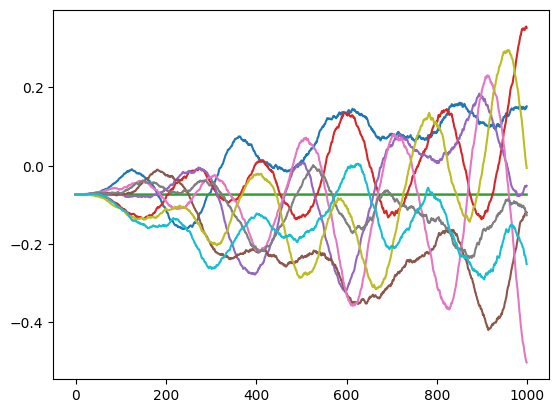

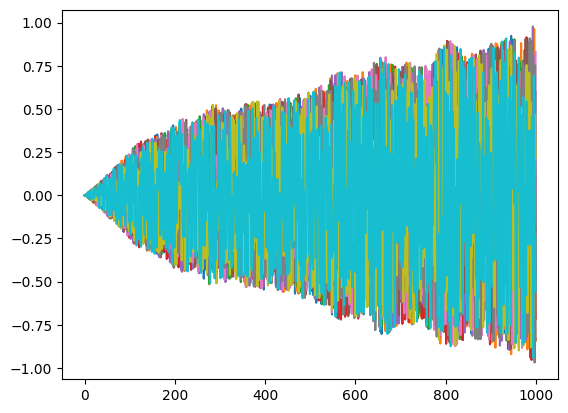

In [1108]:
n_data = 10000
seq_len = 1000

x = np.zeros((n_data, 3))

data = np.empty((seq_len, n_data, 3))
data_sensorial = np.empty((seq_len, n_data, 3))

for i in range(seq_len):
    x :np.ndarray = np.dot(F, x.reshape(-1, 3).T).T.reshape(x.shape)

    x_range = np.sqrt(x.max(axis=0))

    if x_range[2] == 0:
        x_range[2] = 5

    Gu = np.zeros((n_data, 3))
    Gu[:, 0] = x_range[0]*(np.random.rand(n_data)-0.5)
    Gu[:, 1] = x_range[1]*(np.random.rand(n_data)-0.5)
    Gu[:, 2] = x_range[2]*(np.random.rand(n_data)-0.5)

    x += Gu
    
    x[1] = np.clip(x[1], -1, 1)
    x[2] = np.clip(x[1], -1, 1)

    data[i] = x
    data_sensorial[i] = Gu #np.dot(H, Gu.reshape(-1, 3).T).T.reshape(data_sensorial[i].shape)

data = np.transpose(data, (1, 0, 2))
data_sensorial = np.transpose(data_sensorial, (1,0,2))

data_max = data[:,:,0].max()
data_min = data[:,:,0].min()

data = (data - data_min)/(data_max-data_min)
data = 2*(data-0.5)

data_sensorial = (data_sensorial - data_sensorial.min())/(data_sensorial.max()-data_sensorial.min())
data_sensorial = 2*(data_sensorial-0.5)

print(data_max, data_min)
print(data.max(), data.min())

for i in range(10):
    plt.plot(data[i,:,0])
plt.show()

for i in range(10):
    plt.plot(data_sensorial[i,:,0])
plt.show()

In [1132]:
class PredictNextDataset(Dataset):
    def __init__(self, data:np.ndarray, data_sensorial:np.ndarray, context_size:int,
                 return_dimensions:list[int]|None=None):
        super().__init__()

        self.data = data
        self.data_sensorial = data_sensorial
        self.context_size = context_size
        self.return_dimensions = return_dimensions

        self.size = data.shape[0]*int((data.shape[1]-1)/context_size)


    def __len__(self) -> int:
        return self.size
    
    
    def __getitem__(self, index):
        item_size = (data.shape[1]-1)//self.context_size
        item_index = index // item_size
        item_seq_index = index % item_size

        start = item_seq_index*self.context_size
        end = start+self.context_size

        x = self.data[item_index, start:end].copy()
        y = self.data[item_index, start+1:end+1].copy()

        if self.return_dimensions is not None:
            x = x[:, self.return_dimensions]
            y = y[:, self.return_dimensions]

        #x[:,0] += np.random.normal(0.0, 0.1, size=x[:,0].shape)

        x_sensorial = self.data_sensorial[item_index, start:end].copy()
        y_sensorial = self.data_sensorial[item_index, start+1:end+1].copy()

        x = TensorDict({"state_decoded":torch.Tensor(x),
                        "sensorial":torch.Tensor(x_sensorial)})
        
        y = TensorDict({"state_decoded":torch.Tensor(y),
                        "sensorial":torch.Tensor(y_sensorial)})

        return TensorDict({"inputs":x, "targets":y}, batch_size=[])


In [1133]:
def separate_dataset(x_all):
    """
    Separate the data in train, validation and test.

    Args:
        x_all: all dataset elements.

    Returns:
        : train elements. 
        : validation elements.
        : test elements.
    """
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]

    x_val = x_all[cut1:cut2]

    x_test = x_all[cut2:]

    return x_train, x_val, x_test

In [1134]:
context_size = 200

In [1135]:
data_full = np.empty((data.shape[0], data.shape[1], 6))
data_full[:,:,:3] = data
data_full[:,:,3:] = data_sensorial

train_data, val_data, test_data = separate_dataset(data_full)

datasets = {"train":PredictNextDataset(train_data[:, :, :3], train_data[:, :, 3:], context_size), 
            "val":PredictNextDataset(val_data[:, :, :3], val_data[:, :, 3:], context_size), 
            "test":PredictNextDataset(test_data[:, :, :3], test_data[:, :, 3:], context_size)}

In [1136]:
len(datasets["train"])

24000

In [1137]:
for i in range(len(datasets["train"])):
    try:
        assert datasets["train"][i]["inputs"]["state_decoded"].shape == datasets["train"][i]["targets"]["state_decoded"].shape
    except AssertionError as e:
        print(i)
        raise e

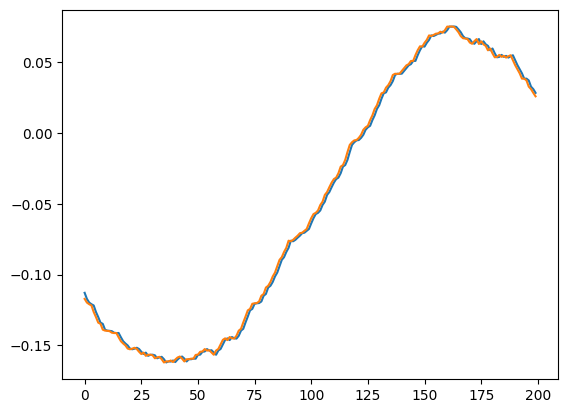

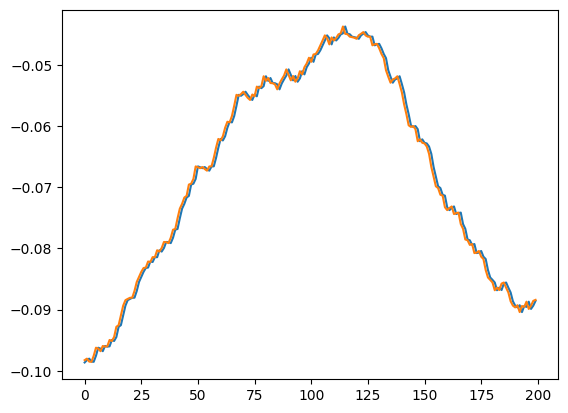

In [1138]:
plt.plot(datasets["train"][1]["inputs"]["state_decoded"][:,0]) 
plt.plot(datasets["train"][1]["targets"]["state_decoded"][:,0])
plt.show()

plt.plot(datasets["train"][1]["inputs"]["state_decoded"][:,1]) 
plt.plot(datasets["train"][1]["targets"]["state_decoded"][:,1])
plt.show()

In [1207]:
return_dimensions = [0]

for name in datasets:
    datasets[name].return_dimensions = return_dimensions

In [1208]:
batch_size = 32

In [1209]:
datasets["train"][0]

TensorDict(
    fields={
        inputs: TensorDict(
            fields={
                sensorial: Tensor(shape=torch.Size([200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                sensorial: Tensor(shape=torch.Size([200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [1210]:
dataloaders = {}
for name in datasets:
    dataloaders[name] = DataLoader(datasets[name], 
                                   batch_size=batch_size, 
                                   collate_fn=lambda x: torch.stack([sample for sample in x]), 
                                   shuffle=True, 
                                    )
                                   #drop_last=True)
next(iter(dataloaders["train"]))

TensorDict(
    fields={
        inputs: TensorDict(
            fields={
                sensorial: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                sensorial: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([32]),
    device=None,
    is_shared=False)

In [1211]:
true_state_dim = len(return_dimensions) if return_dimensions is not None else 3
state_dim = 6

wm = WorldMachine(state_dim=state_dim, max_context_size=context_size)

wm.sensorial_encoders = torch.nn.ModuleDict({"sensorial":torch.nn.Linear(3,state_dim)})
wm.sensorial_decoders = torch.nn.ModuleDict({"sensorial":torch.nn.Linear(state_dim,3)})

blocks = []
#blocks.append(BlockContainer(TransformDecoderBlock(state_dim, state_dim*4, 1, 0.1, True)))
blocks.append(BlockContainer(AdaLNZeroBlock(state_dim, state_dim, state_dim*4, 1),"sensorial"))
blocks.append(BlockContainer(TransformDecoderBlock(state_dim, state_dim*4, 1, 0.1, True)))


wm.blocks = torch.nn.Sequential(*blocks)

wm.state_encoder = torch.nn.Linear(true_state_dim, state_dim)
wm.state_decoder = torch.nn.Linear(state_dim, true_state_dim)

- Colocar encoder e decoder como MLP
- Treino usando estados pré-conhecidos (x e y que temos)
- Adicionar dados sensoriais (H(x_i))
- Treinar com dados sensoriais
- Treinar com ruído
- Model builder

In [1212]:
MODE_TRAIN = 0
MODE_EVALUATE = 1

def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, 
               time:float|None=None):
    """
    Prints the information of a epoch.

    Args:
        loss_value (torch.Tensor): epoch loss.
        epoch (int): epoch number.
        total_epochs (int): total number of epochs. 
        time (float, optional): time to run the epoch. Don't print if is 0.0. Defaults to 0.0.
        accuracy (float, optional): epoch accuracy.
    """

    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}', end="")

    if time is None:
        print("")
    else:
        print(f", Elapsed Time: {time:.2f} sec")
        
def compute_loss_and_optimize(model:torch.nn.Module, 
                 loader:DataLoader, 
                 criterions:dict[torch.nn.Module],
                 loss_name:str, 
                 mode:int = MODE_EVALUATE, 
                 optimizer:torch.optim.Optimizer|None=None, 
                 accumulation_steps:int|None = None) -> dict[str, torch.Tensor]:
    """
    Computes the loss from a model across a dataset.

    If in train mode also runs optimizer steps.

    Args:
        model (torch.nn.Module): model to evaluate.
        loader (DataLoader): dataset.
        criterion (torch.nn.Module): loss function to compute.
        mode (int): mode of the computation. 
                    If MODE_EVALUATE, computes without gradient, in eval mode and detachs loss.
                    If MODE_TRAIN, computes with gradient and in train mode.
                    Default is MODE_EVALUATE.
        optimizer (torch.optim.Optimizer, optional): optimizer to use in the train mode.

    Returns:
        torch.Tensor: resulting loss.
    """
    if accumulation_steps is None:
        accumulation_steps = 1

    original_grad_state = torch.is_grad_enabled()
    original_model_state = model.training

    device = next(iter(model.parameters())).device

    if mode == MODE_EVALUATE:
        model.eval()
        torch.set_grad_enabled(False)
    elif mode == MODE_TRAIN:
        model.train()
        torch.set_grad_enabled(True)
        optimizer.zero_grad()
    else:
        raise ValueError(f"Unknown mode: {mode}.")

    batch_index = 0

    total_loss : dict[str, torch.Tensor] = {}
    for name in criterions:
        total_loss[name] = torch.tensor(0, dtype=torch.float32, device=device)

    n = 0
    for item in tqdm.tqdm(loader):
        item = item.to(device)
        inputs : torch.Tensor = item["inputs"]
        targets : torch.Tensor = item["targets"]["state_decoded"]

        mask = torch.ones((inputs["sensorial"].shape[0], inputs["sensorial"].shape[1]), dtype=bool)
        mask = TensorDict({"sensorial":mask}, batch_size=batch_size)
        
        logits : torch.Tensor = model(inputs, 
                                      mask, 
                                      inputs["state_decoded"])
        logits = logits["state_decoded"]
        #logits = logits.view(-1, logits.shape[-1])

        #print(logits.shape, targets.shape)

        losses : dict[str, torch.Tensor] = {}
        for name in criterions:
            losses[name] = criterions[name](logits, targets)

            total_loss[name] += losses[name]*targets.size(0)
        
        
        n += targets.size(0)

        if mode == MODE_TRAIN:
            loss = losses[loss_name]

            loss /= accumulation_steps
            loss.backward()

            if ((batch_index+1) % accumulation_steps == 0) or (batch_index+1 == len(loader)):
                optimizer.step()
                optimizer.zero_grad()

        batch_index += 1

    for name in total_loss:
        total_loss[name] /= n 
        total_loss[name] = total_loss[name].detach()

    #Return original state
    torch.set_grad_enabled(original_grad_state)
    
    if original_model_state:
        model.train()
    else:
        model.eval()

    return total_loss

def train(model:torch.nn.Module, criterions:dict[str, torch.nn.Module], loss_name:str, optimizer:torch.optim.Optimizer, 
          dataloaders:DataLoader, n_epoch:int, accumulation_steps:int=1,
          use_wandb:bool=False, early_stop:Callable[[float], bool]|None=None) -> dict[str, ArrayLike]:
    
    hist : dict[str, list[torch.Tensor]|list[float]]= {}
    for name in criterions:
        hist[f"loss_train_{name}"] = []
        hist[f"loss_val_{name}"] = []
    hist["time"] = []

    loss_val = compute_loss_and_optimize(model, dataloaders["val"], criterions, loss_name, MODE_EVALUATE)
        
    print("VAL ", end="")
    print_info(loss_val[loss_name], -1, n_epoch)

    for epoch in range(n_epoch):
        start_time = time.time() 

        loss_train = compute_loss_and_optimize(model, dataloaders["train"], criterions, loss_name, MODE_TRAIN, optimizer, accumulation_steps)

        end_time = time.time() 
        
        epoch_duration = end_time - start_time 


        print_info(loss_train[loss_name], epoch, n_epoch, epoch_duration)
        
        #Validation stats
        loss_val = compute_loss_and_optimize(model, dataloaders["val"], criterions, loss_name, MODE_EVALUATE)
        
        print("VAL ", end="")
        print_info(loss_val[loss_name], epoch, n_epoch)

        #Save history and log
        log : dict[str, float] = {}

        for name in criterions:
            hist[f"loss_train_{name}"].append(loss_train[name].item())
            hist[f"loss_val_{name}"].append(loss_val[name].item())
            
            log[f"loss_train_{name}"] = loss_train[name].item()
            log[f"loss_val_{name}"] = loss_val[name].item()

        hist["time"].append(epoch_duration)


        if use_wandb:
            wandb.log(log)

        if (early_stop is not None and 
            early_stop(loss_val[loss_name])):
            break

    for key in hist:
        hist[key] = np.array(hist[key])

    return hist


In [1213]:
class MSELossOnlyFirst(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()

    def forward(self, x, y):
        return self.mse(x[:,:,0], y[:,:,0])

In [ ]:
accumulation_steps = 1 # Passos de acumulação de gradiente
batch_size = 32 # Tamanho de um batch
lr = 5e-3 # Taxa de treinamento
n_epoch = 5 # Quantidade de epochs
optimizer_class = torch.optim.Adam # Otimizador
seed = 42
train_loss = "mse0"
weight_decay = 5e-4 # Regularização L2

criterions = {}
criterions["mse"] = torch.nn.MSELoss()
criterions["mse0"] = MSELossOnlyFirst()
optimizer = optimizer_class(wm.parameters(), lr=lr, weight_decay=weight_decay)

In [1215]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wm.to(device);

In [ ]:
torch.autograd.set_detect_anomaly(False)
train_history = train(wm, criterions, train_loss, optimizer,
                      dataloaders, n_epoch, accumulation_steps,
                      False, None)

100%|██████████| 250/250 [00:02<00:00, 110.04it/s]


VAL Epoch [0/5],             Loss: 0.4119


100%|██████████| 750/750 [00:10<00:00, 69.72it/s]


Epoch [1/5],             Loss: 0.0035, Elapsed Time: 10.83 sec


100%|██████████| 250/250 [00:01<00:00, 127.42it/s]


VAL Epoch [1/5],             Loss: 0.0002


100%|██████████| 750/750 [00:09<00:00, 76.49it/s]


Epoch [2/5],             Loss: 0.0003, Elapsed Time: 9.87 sec


100%|██████████| 250/250 [00:01<00:00, 129.74it/s]


VAL Epoch [2/5],             Loss: 0.0001


100%|██████████| 750/750 [00:09<00:00, 77.94it/s]


Epoch [3/5],             Loss: 0.0001, Elapsed Time: 9.69 sec


100%|██████████| 250/250 [00:01<00:00, 142.86it/s]


VAL Epoch [3/5],             Loss: 0.0002


100%|██████████| 750/750 [00:09<00:00, 80.50it/s]


Epoch [4/5],             Loss: 0.0001, Elapsed Time: 9.38 sec


100%|██████████| 250/250 [00:01<00:00, 135.14it/s]


VAL Epoch [4/5],             Loss: 0.0001


100%|██████████| 750/750 [00:09<00:00, 79.28it/s]


Epoch [5/5],             Loss: 0.0001, Elapsed Time: 9.52 sec


100%|██████████| 250/250 [00:01<00:00, 140.45it/s]

VAL Epoch [5/5],             Loss: 0.0001


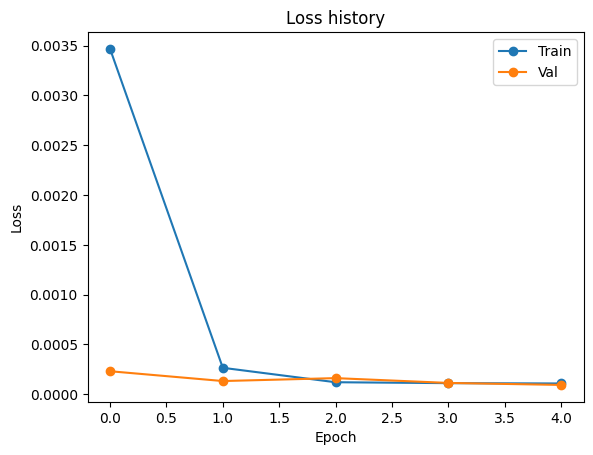

In [1217]:
plt.plot(train_history["loss_train_mse"], "o-")
plt.plot(train_history["loss_val_mse"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()


In [1218]:
item = next(iter(dataloaders["train"]))

inputs : torch.Tensor = item["inputs"].to(device)
targets : torch.Tensor = item["targets"]["state_decoded"]

mask = torch.ones((inputs["sensorial"].shape[0], inputs["sensorial"].shape[1]), dtype=bool)
mask = TensorDict({"sensorial":mask}, batch_size=batch_size)

with torch.no_grad():
    logits : torch.Tensor = wm(inputs, 
                mask, 
                inputs["state_decoded"])

In [1219]:
logits = logits.cpu().numpy()

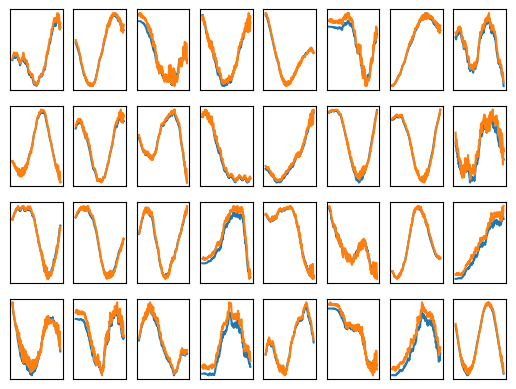

In [1220]:
axis = 0
fig, axs = plt.subplots(4, 8)

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(targets[i,:,axis])
    axs[row, column].plot(logits["state_decoded"][i][:,axis])

    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])
plt.show()

In [1221]:
train_history["loss_train_mse0"][-1]

np.float64(0.00010853292769752443)

In [1222]:
'{:f}'.format(train_history["loss_train_mse0"][-1])

'0.000109'

Mode|Value
-|-
Only x|0.004323231056332588
All 3 |0.0033392785117030144
All 3 + Sensorial | 0.0036886681336909533


Sem ruído x[0]

Mode|Value
-|-
Only x|0.00014687536167912185
All 3 |0.00025092705618590117
All 3 + Sensorial |0.00021077549899928272


Sem ruído x[0] + otimizando apenas x[0] sempre

Mode|Value
-|-
Only x|0.00014687536167912185
All 3 |0.00010992414900101721
All 3 + Sensorial |0.00008020181121537462
Only x + Sensorial|0.00010853292769752443

- Precisa comparar dados sensoriais dentro do estado e condicional (embora colocar dados sensoriais ajudou)
- Criar dados sensoriais de verdade: $H(x_{i+1})$